In [1]:
import json
import random
from pathlib import Path

import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import plotly.express as px


In [2]:
def find_repo_root(marker=".git"):
    here = Path.cwd() if "__file__" not in globals() else Path(__file__).resolve()
    for candidate in [here, *here.parents]:
        if (candidate / marker).exists():
            return candidate
    return here

ROOT = find_repo_root()
DATA = ROOT / "data"

RAW_DIR = DATA / "raw"
LLM_DIR = DATA / "llm"
CLEANED_DIR = DATA / "cleaned"
PROCESSED_IMG_DIR = DATA / "processed" / "images_hashed"
ANALYSIS_DIR = DATA / "analysis"

ANNOT_FILE = CLEANED_DIR / "annotations_fully_cleaned.jsonl"

print("Annotations file:", ANNOT_FILE.resolve())
print("Exists? ->", ANNOT_FILE.exists())

df = pd.read_json(ANNOT_FILE, lines=True)
print("Rows:", len(df))
df.head()


Annotations file: /home/alex/coding/pedestrian-data-mlm-labeling/data/cleaned/annotations_fully_cleaned.jsonl
Exists? -> True
Rows: 82


,image,affordance_tags,walkability,risk_level,surface,nav_cue,lighting,density,text_description,source_file,objects,segments,scene_graph,affordance_conflicts,_validation
0,f294b5d8cfe44cae.jpg,"[sidewalk, road]",0.80,medium,pavement,"Continue straight on the sidewalk, which runs ...",night,low,The scene depicts a residential street at nigh...,IMG_7404.JPEG,"[{'label': 'car', 'bbox': [297, 424, 518, 529]...","[{'label': 'road', 'polygon': [[0, 526], [750,...","[car - driving on - road, street light - illum...",[],"{'ok': True, 'errors': [], 'warnings': [], 'ex..."
1,c97173c298be1411.jpg,"[sidewalk, road, turn_left, turn_right]",0.80,low,pavement,A school zone warning sign and a '30' speed li...,day,low,A yellow Post auto van is parked on the side o...,IMG_7328.JPEG,"[{'label': 'van', 'bbox': [197, 240, 649, 588]...","[{'label': 'road', 'polygon': [[0, 767], [0, 4...","[van - parked on - road, sidewalk - next to - ...",[Van - partially blocks - bike lane],"{'ok': True, 'errors': [], 'warnings': [], 'ex..."
2,175634c61e022cd5.jpg,"[stairs, sidewalk]",0.75,medium,pavement,An illuminated pathway and a set of stairs lea...,night,empty,A dimly lit outdoor scene at night features a ...,IMG_7382.JPEG,"[{'label': 'streetlight', 'bbox': [462, 172, 6...","[{'label': 'stairs', 'polygon': [[0, 999], [0,...","[stairs - next to - sidewalk, streetlight - il...",[],"{'ok': True, 'errors': [], 'warnings': [], 'ex..."
3,86e7f0ea27620635.jpg,"[sidewalk, road, narrow_passage]",0.60,medium,pavement,A construction barrier indicates a blocked pat...,day,empty,The image captures a paved street scene with a...,IMG_7320.JPEG,"[{'label': 'scaffolding', 'bbox': [88, 226, 42...","[{'label': 'road', 'polygon': [[0, 574], [1000...","[scaffolding - is in front of - building, cons...",[sidewalk access is obstructed by scaffolding ...,"{'ok': True, 'errors': [], 'warnings': [], 'ex..."
4,30e74ded4d3a44bb.jpg,"[sidewalk, narrow_passage, turn_right]",0.80,low,pavement,A paved path with a yellow line on the right l...,day,empty,"A narrow paved path, partially covered with au...",IMG_7329.JPEG,"[{'label': 'covered scooter', 'bbox': [223, 29...","[{'label': 'sidewalk', 'polygon': [[0, 483], [...","[pavement - covered with - leaves, scooter - p...",[sidewalk partially covered with leaves might ...,"{'ok': True, 'errors': [], 'warnings': [], 'ex..."


In [3]:
df.columns.tolist()


['image',
 'affordance_tags',
 'walkability',
 'risk_level',
 'surface',
 'nav_cue',
 'lighting',
 'density',
 'text_description',
 'source_file',
 'objects',
 'segments',
 'scene_graph',
 'affordance_conflicts',
 '_validation']

In [4]:
df.sample(1).T


,68
image,672082b985209c83.jpg
affordance_tags,"[sidewalk, road, crosswalk]"
walkability,0.75
risk_level,medium
surface,pavement
nav_cue,Construction barriers partially obstruct the s...
lighting,day
density,empty
text_description,The image shows a sidewalk partially blocked b...
source_file,IMG_7337.JPEG


In [5]:
df['walkability'] = pd.to_numeric(df['walkability'], errors='coerce')

df.info()
df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   image                 82 non-null     object 
 1   affordance_tags       82 non-null     object 
 2   walkability           82 non-null     float64
 3   risk_level            82 non-null     object 
 4   surface               82 non-null     object 
 5   nav_cue               82 non-null     object 
 6   lighting              82 non-null     object 
 7   density               82 non-null     object 
 8   text_description      82 non-null     object 
 9   source_file           82 non-null     object 
 10  objects               82 non-null     object 
 11  segments              82 non-null     object 
 12  scene_graph           82 non-null     object 
 13  affordance_conflicts  82 non-null     object 
 14  _validation           82 non-null     object 
dtypes: float64(1), object(14)

,image,affordance_tags,walkability,risk_level,surface,nav_cue,lighting,density,text_description,source_file,objects,segments,scene_graph,affordance_conflicts,_validation
0,f294b5d8cfe44cae.jpg,"[sidewalk, road]",0.8,medium,pavement,"Continue straight on the sidewalk, which runs ...",night,low,The scene depicts a residential street at nigh...,IMG_7404.JPEG,"[{'label': 'car', 'bbox': [297, 424, 518, 529]...","[{'label': 'road', 'polygon': [[0, 526], [750,...","[car - driving on - road, street light - illum...",[],"{'ok': True, 'errors': [], 'warnings': [], 'ex..."
1,c97173c298be1411.jpg,"[sidewalk, road, turn_left, turn_right]",0.8,low,pavement,A school zone warning sign and a '30' speed li...,day,low,A yellow Post auto van is parked on the side o...,IMG_7328.JPEG,"[{'label': 'van', 'bbox': [197, 240, 649, 588]...","[{'label': 'road', 'polygon': [[0, 767], [0, 4...","[van - parked on - road, sidewalk - next to - ...",[Van - partially blocks - bike lane],"{'ok': True, 'errors': [], 'warnings': [], 'ex..."


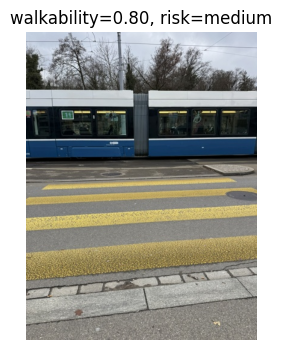


text_description:
A blue and white tram is stopped on tracks next to a paved road with a prominent yellow-striped crosswalk. The scene is set on an overcast day with bare trees lining the background, indicating cooler weather.
------------------------------------------------------------


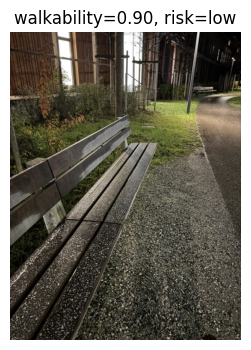


text_description:
A well-lit pedestrian path curves to the right at night, bordered by a wooden bench and a grassy area. Tall buildings with windows are visible in the background, with sparse trees lining the path.
------------------------------------------------------------


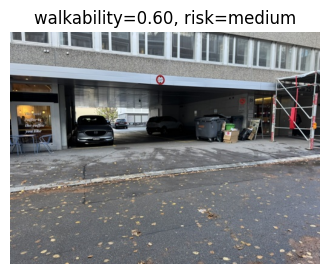


text_description:
The scene shows a paved area in front of a modern building, featuring a coffee shop on the left and a vehicle entrance under an overhang leading to an interior area. Several cars are present, along with waste bins and scaffolding. The ground is scattered with autumn leaves, indicating the season.
------------------------------------------------------------


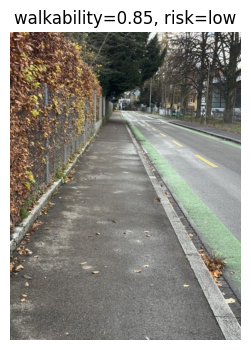


text_description:
The image shows a paved sidewalk stretching into the distance, next to a road. A tall hedge with autumn leaves runs alongside a fence on the left, while a green-marked bike lane separates the sidewalk from the main road on the right. The path appears clear for pedestrian navigation.
------------------------------------------------------------


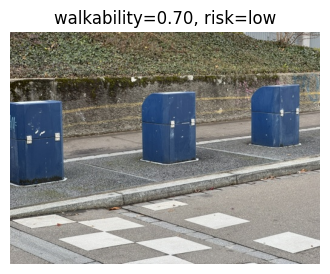


text_description:
The image shows a pedestrian area with three blue bollards on a gravel-like surface, separating it from a road. A black and white checkered crosswalk pattern is visible on the road in the foreground. A concrete wall with overgrown vegetation forms the background.
------------------------------------------------------------


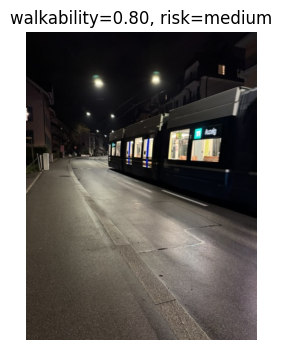


text_description:
The scene depicts a well-lit street at night, with a tram moving on tracks. A clear sidewalk runs alongside the road, separating pedestrians from vehicle traffic. Buildings line the left side of the street.
------------------------------------------------------------


In [6]:
from PIL import Image
import matplotlib.pyplot as plt
import json

sample = df.sample(6, random_state=1)

for _, row in sample.iterrows():
    img_path = PROCESSED_IMG_DIR / row['image']
    img = Image.open(img_path)

    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"walkability={row['walkability']:.2f}, risk={row['risk_level']}")
    plt.show()

    print("\ntext_description:")
    print(row['text_description'])
    print("-" * 60)


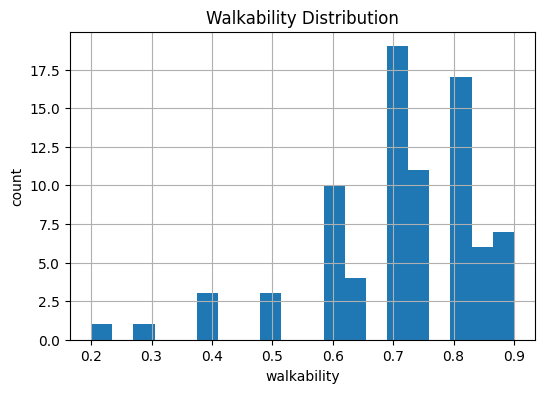

In [7]:
plt.figure(figsize=(6,4))
df['walkability'].hist(bins=20)
plt.title("Walkability Distribution")
plt.xlabel("walkability")
plt.ylabel("count")
plt.show()

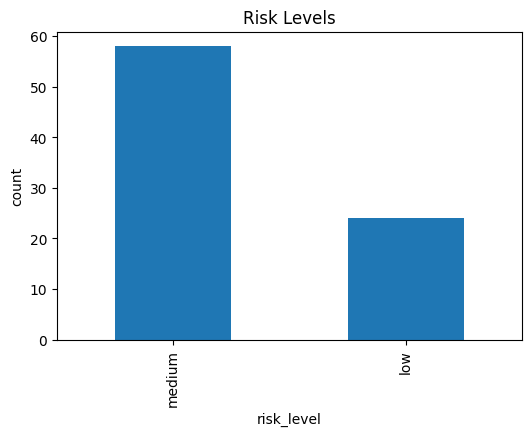

In [8]:
df['risk_level'].value_counts().plot.bar(figsize=(6,4))
plt.title("Risk Levels")
plt.ylabel("count")
plt.show()


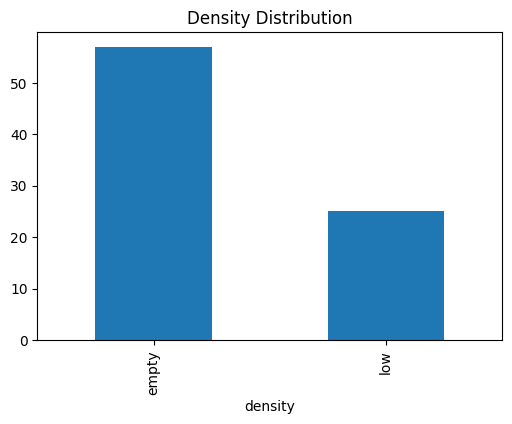

In [9]:
df['density'].value_counts().plot.bar(figsize=(6,4))
plt.title("Density Distribution")
plt.show()

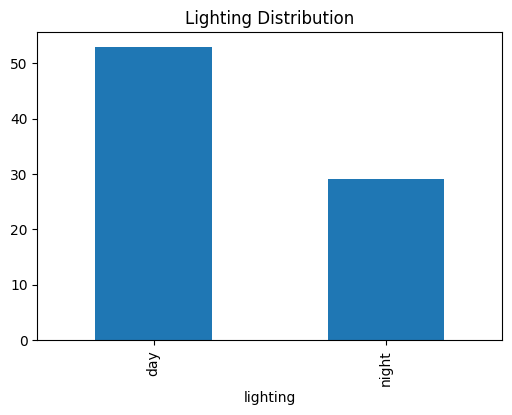

In [10]:
df['lighting'].value_counts().plot.bar(figsize=(6,4))
plt.title("Lighting Distribution")
plt.show()


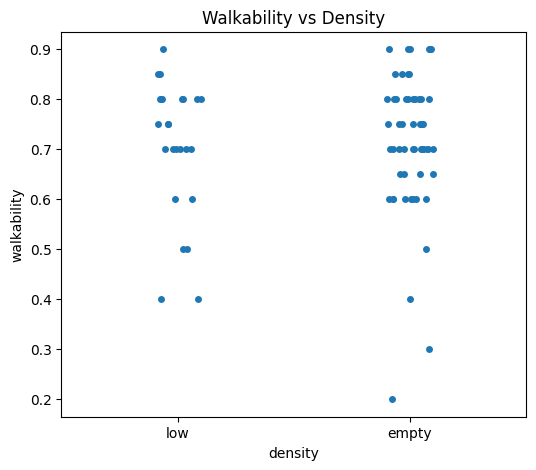

In [11]:
import seaborn as sns

plt.figure(figsize=(6,5))
sns.stripplot(data=df, x='density', y='walkability', jitter=True)
plt.title("Walkability vs Density")
plt.show()


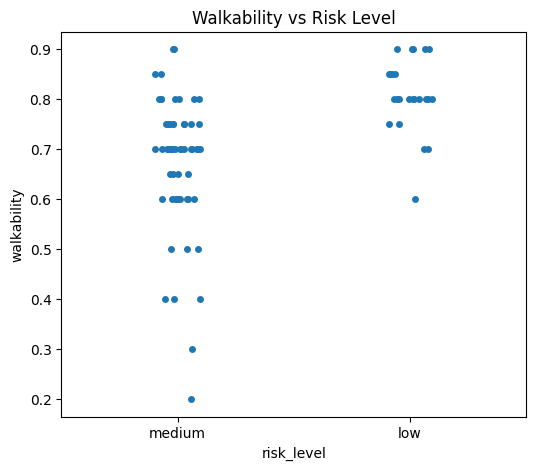

In [12]:
plt.figure(figsize=(6,5))
sns.stripplot(data=df, x='risk_level', y='walkability', jitter=True)
plt.title("Walkability vs Risk Level")
plt.show()


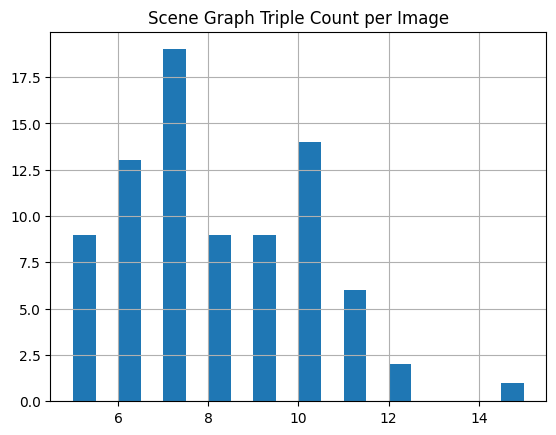

In [13]:
df['num_triples'] = df['scene_graph'].apply(len)

df['num_triples'].hist(bins=20)
plt.title("Scene Graph Triple Count per Image")
plt.show()

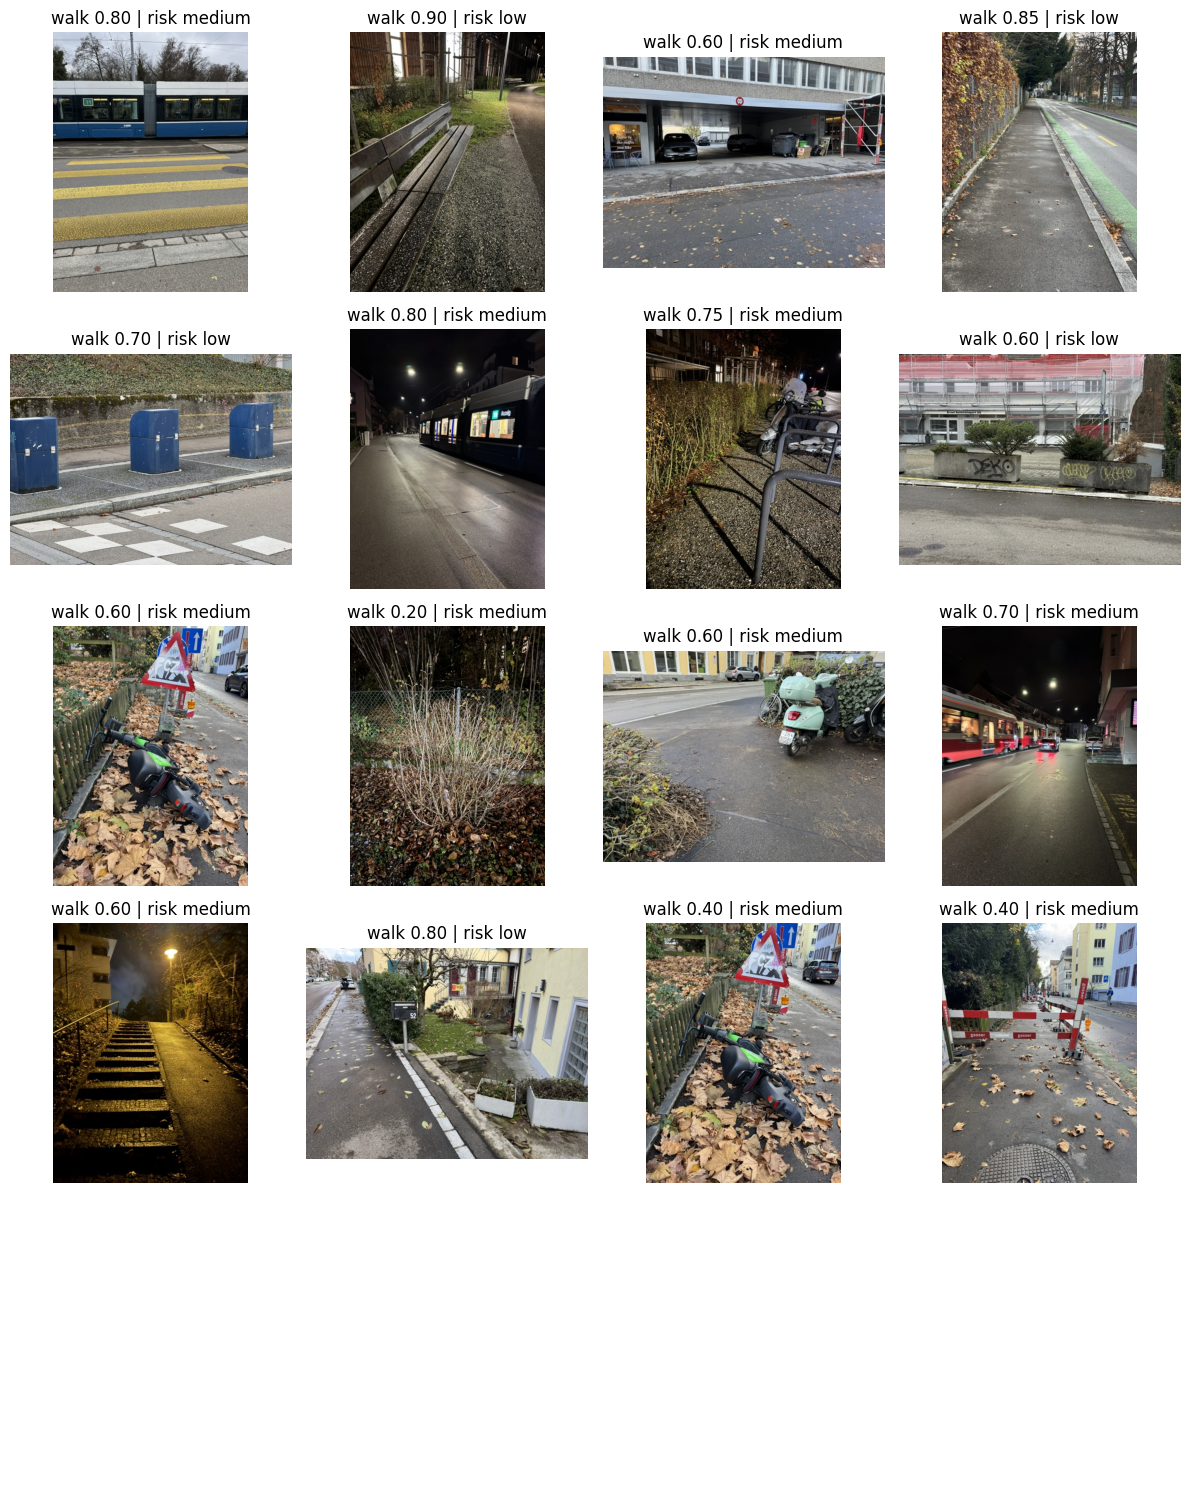

In [14]:
import matplotlib.pyplot as plt
from PIL import Image
import random

def show_image_grid(df, n=12, cols=4):
    rows = (n // cols) + 1
    sample = df.sample(n, random_state=1)
    
    fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
    axes = axes.flatten()
    
    for ax, (_, row) in zip(axes, sample.iterrows()):
        img = Image.open(PROCESSED_IMG_DIR / row["image"])
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"walk {row['walkability']:.2f} | risk {row['risk_level']}")
    
    # Turn off any remaining unused axes
    for ax in axes[len(sample):]:
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

show_image_grid(df, n=16, cols=4)


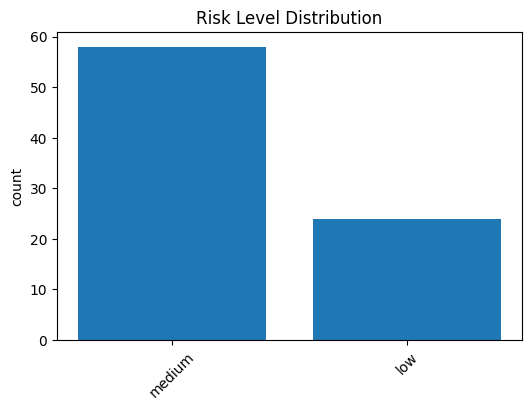

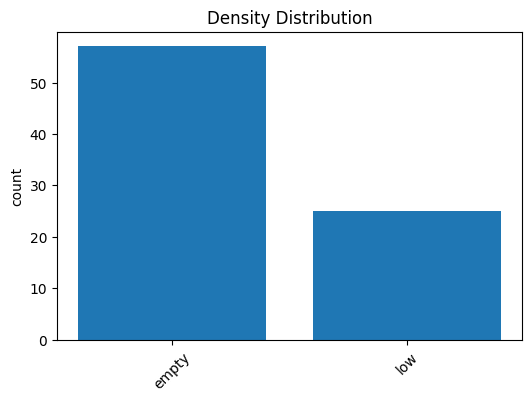

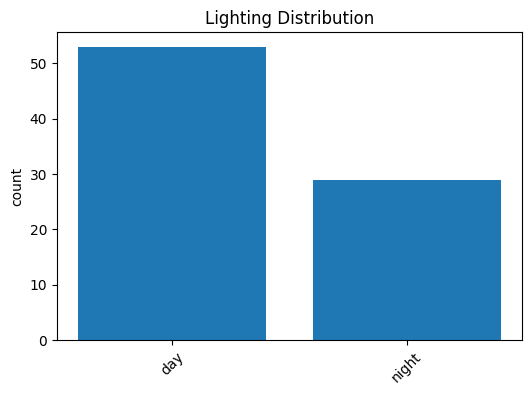

In [15]:
def bar_countplot(series, title):
    counts = series.value_counts()
    plt.figure(figsize=(6,4))
    plt.bar(counts.index, counts.values)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.ylabel("count")
    plt.show()

bar_countplot(df['risk_level'], "Risk Level Distribution")
bar_countplot(df['density'], "Density Distribution")
bar_countplot(df['lighting'], "Lighting Distribution")


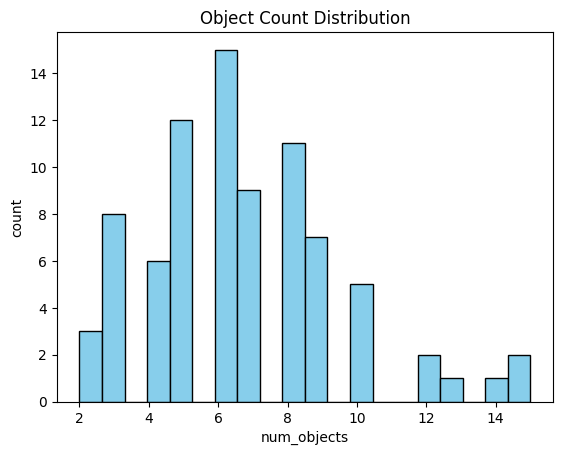

In [16]:
def safe_len(x):
    if isinstance(x, list):
        return len(x)
    return 0  # treat NaN or malformed as empty

df["num_objects"] = df["objects"].apply(safe_len)

plt.hist(df['num_objects'], bins=20, color="skyblue", edgecolor="black")
plt.title("Object Count Distribution")
plt.xlabel("num_objects")
plt.ylabel("count")
plt.show()
